In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd

In [2]:
# leer en df_full ./data/l_vm_completa_train.parquet
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet')
print(df_full.shape)

(12254054, 55)


In [3]:
# Variables categóricas
# categorical_features = ['CUSTOMER_ID','PRODUCT_ID','ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['CUSTOMER_ID','PRODUCT_ID']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')
# Asegurarse de que las variables predictoras y objetivo estén en el formato correcto
# Imprimir los tipos de datos de las columnas del DataFrame completo
print(df_full.dtypes)

PERIODO                         int64
ANIO                            int64
MES                             int64
MES_SIN                       float64
MES_COS                       float64
TRIMESTRE                       int64
ID_CAT1                         int64
ID_CAT2                         int64
ID_CAT3                         int64
ID_BRAND                        int64
SKU_SIZE                        int64
CUSTOMER_ID                  category
PRODUCT_ID                   category
PLAN_PRECIOS_CUIDADOS           int64
CUST_REQUEST_QTY                int64
CUST_REQUEST_TN               float64
TN                            float64
STOCK_FINAL                   float64
MEDIA_MOVIL_3M_CLI_PROD       float64
MEDIA_MOVIL_6M_CLI_PROD       float64
MEDIA_MOVIL_12M_CLI_PROD      float64
DESVIO_MOVIL_3M_CLI_PROD      float64
DESVIO_MOVIL_6M_CLI_PROD      float64
DESVIO_MOVIL_12M_CLI_PROD     float64
MEDIA_MOVIL_3M_PROD           float64
MEDIA_MOVIL_6M_PROD           float64
MEDIA_MOVIL_

In [4]:
# Variables categóricas
categorical_features = ['ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','CUSTOMER_ID','PRODUCT_ID','PLAN_PRECIOS_CUIDADOS']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')


In [8]:

# filtrar que en X el periodo sea menor o igual a 201910
# Variables predictoras y objetivo
# En x eliminar la columna 'CLASE' y 'CLASE_DELTA'
X = df_full[df_full['PERIODO'] <= 201910].drop(columns=['CLASE', 'CLASE_DELTA']) 
# Filtrar en y que el periodo sea menor o igual a 201910
y = df_full[df_full['PERIODO'] <= 201910]['CLASE']
df_full['CLASE_BIN'] = (df_full['CLASE'] > 0).astype(int)
# Filtrar en y que el periodo sea menor o igual a 201910
y_bin = df_full[df_full['PERIODO'] <= 201910]['CLASE_BIN']


In [9]:
# Definir los periodos de validación 201909, 201910
periodos_valid = [201909,201910]


# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['PERIODO'] < periodos_valid[0]]
y_train = y[X['PERIODO'] < periodos_valid[0]]
y_bin_train = y_bin[X['PERIODO'] < periodos_valid[0]]

X_val_list = [X[X['PERIODO'] == p] for p in periodos_valid]
y_val_list = [y[X['PERIODO'] == p] for p in periodos_valid]
y_bin_val_list = [y_bin[X['PERIODO'] == p] for p in periodos_valid]



In [11]:


# Entrenar el modelo LightGBM para clasificación binaria donde la variable objetivo es 'CLASE' 
# si 0 o distinta de 0 usando early stopping sobre el conjunto de validación
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
# Crear el dataset de LightGBM
lgb_train = lgb.Dataset(X_train, y_bin_train,  categorical_feature=categorical_features)
lgb_val_list = [lgb.Dataset(X_val, y_bin_val_list, categorical_feature=categorical_features) for X_val, y_bin_val_list in zip(X_val_list, y_bin_val_list)]    
# Entrenar el modelo
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_val_list,
    valid_names=[f'valid_{i+1}' for i in range(len(lgb_val_list))],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=10)
    ]
)
# Guardar el modelo entrenado
model.save_model('lgbm_model.txt')


Training until validation scores don't improve for 50 rounds
[10]	valid_1's binary_logloss: 0.336934	valid_2's binary_logloss: 0.30191
[20]	valid_1's binary_logloss: 0.300623	valid_2's binary_logloss: 0.26984
[30]	valid_1's binary_logloss: 0.282376	valid_2's binary_logloss: 0.253945
[40]	valid_1's binary_logloss: 0.272191	valid_2's binary_logloss: 0.245014
[50]	valid_1's binary_logloss: 0.265986	valid_2's binary_logloss: 0.23932
[60]	valid_1's binary_logloss: 0.261907	valid_2's binary_logloss: 0.235519
[70]	valid_1's binary_logloss: 0.25916	valid_2's binary_logloss: 0.232942
[80]	valid_1's binary_logloss: 0.257021	valid_2's binary_logloss: 0.230364
[90]	valid_1's binary_logloss: 0.255664	valid_2's binary_logloss: 0.228644
[100]	valid_1's binary_logloss: 0.254795	valid_2's binary_logloss: 0.227098
[110]	valid_1's binary_logloss: 0.253945	valid_2's binary_logloss: 0.2261
[120]	valid_1's binary_logloss: 0.2534	valid_2's binary_logloss: 0.225396
[130]	valid_1's binary_logloss: 0.252917	val

KeyboardInterrupt: 

In [115]:

import lightgbm as lgb

# Crear los datasets de LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data_list = [lgb.Dataset(X_val_list[i], label=y_val_list[i], categorical_feature=categorical_features) for i in range(len(periodos_valid))]

# Definir parámetros para regresión
params = { 
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 1024,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Entrenar el modelo con validación múltiple y early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=10000,
    valid_sets=val_data_list,
    valid_names=[f'validation_{p}' for p in periodos_valid],
    callbacks=[lgb.early_stopping(stopping_rounds=500), lgb.log_evaluation(period=500)]
)

print("Modelo de regresión entrenado con cinco conjuntos de validación (uno por cada periodo 201906-201910).")

Training until validation scores don't improve for 500 rounds
[500]	validation_201908's l1: 0.0585812	validation_201909's l1: 0.0597175	validation_201910's l1: 0.0558093
[1000]	validation_201908's l1: 0.0578526	validation_201909's l1: 0.0583706	validation_201910's l1: 0.054446
[1500]	validation_201908's l1: 0.0578417	validation_201909's l1: 0.0582442	validation_201910's l1: 0.0541707
Early stopping, best iteration is:
[1215]	validation_201908's l1: 0.0577914	validation_201909's l1: 0.0582312	validation_201910's l1: 0.0542489
Modelo de regresión entrenado con cinco conjuntos de validación (uno por cada periodo 201906-201910).


       feature    importance
3  TN_DELTA_01  3.548246e+08
4  TN_DELTA_02  1.830971e+08
5  TN_DELTA_03  1.812389e+08
0      PERIODO  1.711841e+08
1  CUSTOMER_ID  1.708743e+08
6  TN_DELTA_06  1.513467e+08
2   PRODUCT_ID  1.459133e+08
7  TN_DELTA_12  1.105467e+08


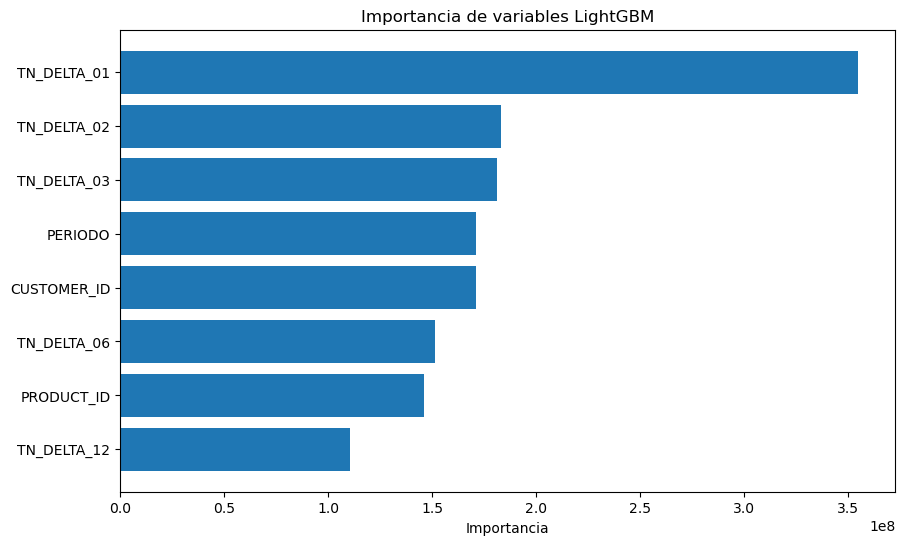

In [116]:
# Obtener la importancia de cada variable
importancia = model.feature_importance(importance_type='gain')
nombres = X_train.columns

# Crear un DataFrame ordenado por importancia
import pandas as pd
df_importancia = pd.DataFrame({'feature': nombres, 'importance': importancia})
df_importancia = df_importancia.sort_values(by='importance', ascending=False)

# Mostrar las variables más importantes
print(df_importancia)

# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables LightGBM')
plt.xlabel('Importancia')
plt.show()

In [117]:
# Guardo el modelo entrenado
model.save_model('modelo_regresion_lgbm_lags_delta_promedio_desvio.txt')

In [118]:
# Cargo los datos sobre los que quiero hacer predicciones

conn =  cx_Oracle.connect(user="pc",password="p201404",dsn="siatchdesa")
query = "select * from L_VM_COMPLETA where periodo = 201912" 
df_pred = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM

# Para concatenar todos los chunks en un solo DataFrame (si tienes suficiente RAM)
df_pred_full = pd.concat(df_pred, ignore_index=True)
conn.close()

C:\Users\pcablinski.RWD\AppData\Local\Temp\ipykernel_59612\2746725373.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pred = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM


In [119]:
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_pred_full[col] = df_pred_full[col].astype('category')

# Con el modelo entrenado, hacemos predicciones 
X_pred = df_pred_full[['PERIODO','CUSTOMER_ID','PRODUCT_ID',
'TN_DELTA_01','TN_DELTA_02','TN_DELTA_03','TN_DELTA_06','TN_DELTA_12']]


In [120]:

predictions = model.predict(X_pred)
# Agregar las predicciones al DataFrame original
df_pred_full['PREDICCIONES'] = predictions
# Imprimir las primeras filas del DataFrame con las predicciones
print(df_pred_full.head())
# Guardar el DataFrame con las predicciones en un archivo CSV
df_pred_full.to_csv('predicciones.csv', index=False)
# Imprimir el número de filas y columnas del DataFrame con las predicciones
print(f"Número de filas: {df_pred_full.shape[0]}, Número de columnas: {df_pred_full.shape[1]} con predicciones.")



   PERIODO  ANIO  MES  TRIMESTRE  ID_CAT1  ID_CAT2  ID_CAT3  ID_BRAND  \
0   201912  2019   12          4        2       11       57         1   
1   201912  2019   12          4        2       11       57         1   
2   201912  2019   12          4        2       11       57         1   
3   201912  2019   12          4        2       11       57         1   
4   201912  2019   12          4        2       11       57         1   

   SKU_SIZE CUSTOMER_ID  ...  TN_LAG_06  TN_LAG_12  CLASE  CLASE_DELTA  \
0      3000       10001  ...   65.92436  254.62373   None         None   
1      3000       10002  ...  144.07021  131.28861   None         None   
2      3000       10003  ...    0.00000   98.91454   None         None   
3      3000       10004  ...   66.71971  236.78999   None         None   
4      3000       10005  ...    0.00000   19.35723   None         None   

   TN_DELTA_01  TN_DELTA_02  TN_DELTA_03  TN_DELTA_06  TN_DELTA_12  \
0    -56.43618      4.18958     71.16694    11

In [121]:
# Con el DataFrame de predicción, actualizamos la base de datos
# el criterio es actualizar la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones
# la columnna PREDICCIONES se debe actualizar con los nuevos valores
# la clave primaria es (PERIODO, CUSTOMER_ID, PRODUCT_ID)
# Hacer commit cada 10000 filas para evitar problemas de memoria

# Conectar a la base de datos para actualizar los datos de predicción
conn = cx_Oracle.connect(user="pc", password="p201404", dsn="siatchdesa")
# Crear un cursor para ejecutar las actualizaciones
cursor = conn.cursor()
update_query = """
    UPDATE L_VM_COMPLETA_PREDICCIONES
    SET PREDICCION = NULL
"""
cursor.execute(update_query)
# Hacer commit para aplicar el cambio de NULL
conn.commit()


In [ ]:


# Imprimir mensaje de inicio de actualización
print("Iniciando actualización de la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.")

# Iterar sobre las filas del DataFrame con las predicciones
for index, row in df_pred_full.iterrows():
    periodo = row['PERIODO']
    customer_id = row['CUSTOMER_ID']
    product_id = row['PRODUCT_ID']
    prediccion = row['TN'] + row['PREDICCIONES']
   # prediccion = row['PREDICCIONES']
    
    # Actualizar la tabla L_DATOS_PREDICCION con la nueva predicción
    update_query = """
        UPDATE L_VM_COMPLETA_PREDICCIONES
        SET PREDICCION = :prediccion
        WHERE PERIODO = :periodo AND CUSTOMER_ID = :customer_id AND PRODUCT_ID = :product_id
    """
    cursor.execute(update_query, {'prediccion': prediccion, 'periodo': periodo, 'customer_id': customer_id, 'product_id': product_id})  
    # Hacer commit cada 10000 filas para evitar problemas de memoria
    if index % 10000 == 0:
        conn.commit()
        print(f"Actualizadas {index} filas de L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.")
# Confirmar los cambios en la base de datos
conn.commit()
# Cerrar el cursor y la conexión
cursor.close()
conn.close()
# Imprimir mensaje de finalización
print("Actualización de la tabla  completada con las nuevas predicciones.")


Iniciando actualización de la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.
Actualizadas 0 filas de L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.
Actualizadas 10000 filas de L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.
